# Netflix Analytics - Recomendação de filmes por meio de correlações

Este projeto visa construir um mecanismo de recomendação de filmes dentro da Netflix. O conjunto de dados que usei aqui vem diretamente da Netflix. Consiste em 4 arquivos de dados de texto, cada arquivo contém mais de 20 milhões de linhas, ou seja, filmes em 4K e 400 mil clientes. Ao todo, mais de 17 mil filmes e mais de 500 mil clientes!


Um dos maiores desafios é carregar todos esses dados no Kernel para análise. Muitas vezes, encontrei o Kernel sem memória e tentei várias maneiras diferentes de fazer isso com mais eficiência.

## Instalação e importação de bibliotecas

In [5]:
!pip install scikit-surprise pandas seaborn matplotlib

  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)
     |████████████████████████████████| 8.5 MB 5.0 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 19.7 MB/s eta 0:00:01
     |████████████████████████████████| 61 kB 14.9 MB/s eta 0:00:01
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)


In [6]:
import re
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

sns.set_style("darkgrid")

## Carregamento dos dados
Cada arquivo de dados (existem 4 deles) contém as colunas abaixo:

ID do filme (como primeira linha de cada novo registro/arquivo de filme)
Identificação do Cliente
Classificação (1 a 5)
Data em que deram as classificações
Há outro arquivo que contém o mapeamento do ID do filme para o plano de fundo do filme, como nome, ano de lançamento, etc.

In [7]:
df = pd.read_csv(
  'data/combined_data_1.txt', 
  header=None, 
  names=['Cust_Id', 'Rating'], 
  usecols = [0, 1]
)

df.head()

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


In [8]:
df['Rating'] = df['Rating'].astype(float)

In [10]:
df.shape

(24058263, 2)

In [11]:
df.iloc[::5000000, :]

,Cust_Id,Rating
0,1:,NaN
5000000,2560324,4.0
10000000,2271935,2.0
15000000,1921803,2.0
20000000,1933327,3.0


## Visualização dos dados

In [12]:
df.describe()

,Rating
count,2.405376e+07
mean,3.599634e+00
std,1.086118e+00
min,1.000000e+00
25%,3.000000e+00
50%,4.000000e+00
75%,4.000000e+00
max,5.000000e+00


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24058263 entries, 0 to 24058262
Data columns (total 2 columns):
 #   Column   Dtype  
---  ------   -----  
 0   Cust_Id  object 
 1   Rating   float64
dtypes: float64(1), object(1)
memory usage: 367.1+ MB


In [14]:
df.isnull().sum(axis = 0)

Cust_Id       0
Rating     4499
dtype: int64

array([[<AxesSubplot:title={'center':'Rating'}>]], dtype=object)

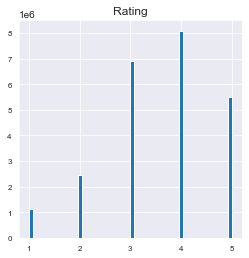

In [15]:
df.hist(figsize=(4, 4), bins=50, xlabelsize=8, ylabelsize=8)

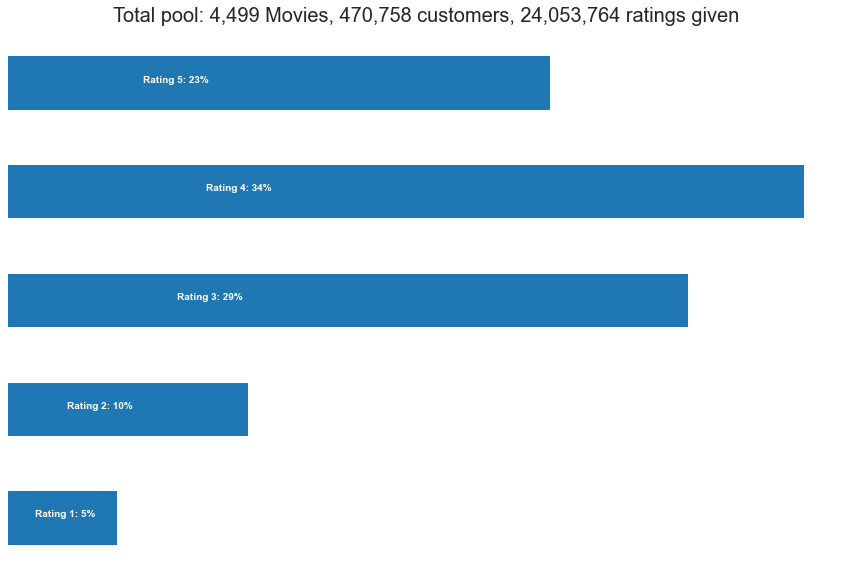

In [16]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df.isnull().sum()[1]

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

## Limpeza dos dados
ID do filme é realmente uma importação bagunçada, fazer um loop pelo dataframe para adicionar a coluna Movie ID FAZER com que o Kernel fique sem memória, pois é muito ineficiente. Eu alcanço minha tarefa criando primeiro uma matriz numpy com comprimento correto e, em seguida, adiciono toda a matriz como coluna no dataframe principal.

In [17]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

In [18]:
movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

In [19]:
# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)
'Movie numpy: {}'.format(movie_np), 'Length: {}'.format(len(movie_np))

('Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]',
 'Length: 24053764')

In [20]:
# remove those Movie ID rows
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
df.iloc[::5000000, :]

,Cust_Id,Rating,Movie_Id
1,1488844,3.0,1
5000996,501954,2.0,996
10001962,404654,5.0,1962
15002876,886608,2.0,2876
20003825,1193835,2.0,3825


## Fatiamento de dados
O conjunto de dados agora é enorme. Eu tentei muitas maneiras diferentes, mas não consigo fazer o Kernel funcionar como pretendido sem erro de memória. Portanto, tentei reduzir o volume de dados melhorando a qualidade dos dados abaixo:

Remova o filme com muito menos comentários (eles são relativamente pouco populares)
Remova o cliente que dá muito menos avaliações (eles são relativamente menos ativos)
Ter um benchmark acima terá uma melhoria significativa na eficiência, uma vez que esses filmes impopulares e clientes não ativos ainda ocupam o mesmo volume que os filmes populares e clientes ativos na visão da matriz (NaN ainda ocupam espaço). Isso também deve ajudar a melhorar a significância estatística.

In [21]:
df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(['count','mean'])
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index
movie_benchmark

1799.0

In [23]:
df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(['count','mean'])
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index
cust_benchmark

52.0

In [24]:
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
df.shape

(17337458, 3)

In [25]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')
df_p.shape

(143458, 1350)

## Mapeamento dos dados dos filmes

In [26]:
df_title = pd.read_csv(
    'data/movie_titles.csv', 
    encoding="ISO-8859-1", 
    header=None, 
    names=['Movie_Id', 'Year', 'Name'], 
    error_bad_lines=False
)

df_title.set_index('Movie_Id', inplace=True)


In [27]:
df_title.shape

(17770, 2)

In [28]:
df_title.head()

,Year,Name
Movie_Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


## Recomendar com filtragem colaborativa
Avalie o desempenho da filtragem colaborativa, com apenas as primeiras 100.000 linhas para um processo mais rápido:

In [30]:
reader = Reader()
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:100000], reader)
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

{'test_rmse': array([0.99336408, 0.99673354, 0.99353041, 0.99914633, 1.00544802]),
 'test_mae': array([0.79862712, 0.80531424, 0.7991539 , 0.80758614, 0.80203383]),
 'fit_time': (4.224030017852783,
  4.227563858032227,
  4.230341196060181,
  4.237452030181885,
  4.244607925415039),
 'test_time': (0.3367013931274414,
  0.08290886878967285,
  0.07877111434936523,
  0.08131980895996094,
  0.0813150405883789)}

### Abaixo está um exemplo do usuário 783514 mostrando o que o mesmo gostou no passado:

In [31]:
df_785314 = df[(df['Cust_Id'] == 785314) & (df['Rating'] == 5)]
df_785314 = df_785314.set_index('Movie_Id')
df_785314 = df_785314.join(df_title)['Name']
df_785314

Movie_Id
57                                            Richard III
175                                        Reservoir Dogs
311                                               Ed Wood
329                                                 Dogma
331                                           Chasing Amy
395                                         Captain Blood
788                                                Clerks
798                                                  Jaws
907                                       Animal Crackers
985                                             The Mummy
1552                                          Black Adder
1905    Pirates of the Caribbean: The Curse of the Bla...
2000                          Four Weddings and a Funeral
2122                                 Being John Malkovich
2342                                        Super Size Me
2360                                  Singin' in the Rain
2430                           Alien: Collector's Edition
2443 

### Agora vamos prever quais filmes o usuário 785314 gostaria de assistir:

In [32]:
user_785314 = df_title.copy()
user_785314 = user_785314.reset_index()
user_785314 = user_785314[~user_785314['Movie_Id'].isin(drop_movie_list)]

In [35]:
# getting full dataset
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:100000], reader)

In [36]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [37]:
user_785314['Estimate_Score'] = user_785314['Movie_Id'].apply(lambda x: svd.predict(785314, x).est)

In [38]:
user_785314 = user_785314.drop('Movie_Id', axis = 1)

In [40]:
user_785314 = user_785314.sort_values('Estimate_Score', ascending=False)
user_785314.head()

,Year,Name,Estimate_Score
2,1997.0,Character,3.435237
27,2002.0,Lilo and Stitch,3.133010
55,2004.0,Carandiru,3.037528
126,1987.0,Fatal Beauty,3.037528
121,2002.0,Cube 2: Hypercube,3.037528


## Recomendar com o coeficiente de correlação de Pearson
A maneira como funciona é que usamos a correlação de Pearson para medir a correlação linear entre as pontuações de revisão de todos os pares de filmes e, em seguida, fornecemos os 10 principais filmes com correlações mais altas:

In [41]:
def recommend(movie_title, min_count):
    print("For movie ({})".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    i = int(df_title.index[df_title['Name'] == movie_title][0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
    print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))

In [42]:
recommend("What the #$*! Do We Know!?", 0)

For movie (What the #$*! Do We Know!?)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                                      Name  count      mean
 1.000000                What the #$*! Do We Know!?  14910  3.189805
 0.505500                                 Inu-Yasha   1883  4.554434
 0.452807  Captain Pantoja and the Special Services   1801  3.417546
 0.442354                 Without a Trace: Season 1   2124  3.980226
 0.384179                      Yu-Gi-Oh!: The Movie   3173  3.331547
 0.383959                                  Scorched   2430  2.894239
 0.381173   All Creatures Great and Small: Series 1   2327  3.938118
 0.381112           As Time Goes By: Series 1 and 2   2249  4.164073
 0.373018                          Cowboys & Angels   2368  3.589527
 0.371981                            Biggie & Tupac   1866  3.019293


In [43]:
recommend("X2: X-Men United", 0)

For movie (X2: X-Men United)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                                                   Name  count      mean
 1.000000                                       X2: X-Men United  98720  3.932202
 0.384550                               Batman Beyond: The Movie   2614  3.726855
 0.375967                                         Justice League   3591  3.710944
 0.361393                       Justice League: Justice on Trial   2961  3.718001
 0.338025                     Batman Beyond: Return of the Joker   3704  3.604752
 0.335256                                          Batman Begins  54922  4.236699
 0.328229                           Batman: Mask of the Phantasm   2823  3.767977
 0.327040  Batman: The Animated Series: Tales of the Dark Knight   2432  3.583059
 0.316666                        Dragon Ball Z: Super Android 13   2426  3.428689
 0.316166                               Mortal Kombat: The Movie   7633  3.165466
